TokaMaker Example 3: Baseline L-mode scenario in ITER {#doc_tMaker_ex3}
==========
In this example we show how to compute equilibria in ITER with L-mode like profiles for:
 1. The "inverse" case where we have a desired shape, plasma current and pressure, but the required coil currents are unkown
 2. The "forward" case where we have already have coil currents, plasma current, and known position for the desired equilibrium

This example utilizes the mesh built in \ref doc_gs_mesh_ex2.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
r'''This example requires use of the Sauter formula for bootstrap current 
(See: O. Sauter, et al., Phys. Plasmas 6, 2834 (1999); doi:10.1063/1.873240). 
It is available as part of the open source platform OMFIT, written as part of 
the Kolemen Group Automatic Kinetic EFIT Project "auto_kEFIT" 
(See: https://omfit.io/_modules/omfit_classes/utils_fusion.html).

This formula can be installed using pip:
$ pip install --upgrade omfit_classes

Then in your python script:
import omfit_classes.utils_fusion.sauter_bootstrap

The utility function Hmode_profiles() 
is also imported to facilitate specification of a pressure pedestal.
'''

from omfit_classes.utils_fusion import sauter_bootstrap, Hmode_profiles

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [3]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [4]:
mygs = TokaMaker()

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          e283e6c
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_gs_mesh_ex2 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.827E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.1340000000000000E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the actual ITER Vertical Stability Coil (VSC).

In [6]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[coil_dict['VSU']['coil_id'], coil_dict['VSL']['coil_id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [7]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -50.E6; coil_bounds[:,1] = 50.E6
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [8]:
Ip_target=15.6E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [9]:
isoflux_pts = np.array([
    [ 8.20,  0.41],
    [ 8.06,  1.46],
    [ 7.51,  2.62],
    [ 6.14,  3.78],
    [ 4.51,  3.02],
    [ 4.26,  1.33],
    [ 4.28,  0.08],
    [ 4.49, -1.34],
    [ 7.28, -1.89],
    [ 8.00, -0.68]
])
x_point = np.array([[5.125, -3.4],])
mygs.set_isoflux(np.vstack((isoflux_pts,x_point)))
mygs.set_saddles(x_point)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on the CS and PF coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the VSC set has a large weight as we also use the regularization matrix to prevent up-down symmetric current in these coils. The actual up-down asymmetric current will be provided by the dedicated VSC virtual coil.

In [10]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Set regularization weights
for key, coil in coil_dict.items():
    if key.startswith('CS'):
        if key.startswith('CS1'):
            coil_reg_weights[coil['coil_id']] = 2.E-2
        else:
            coil_reg_weights[coil['coil_id']] = 1.E-2
    elif key.startswith('PF'):
        coil_reg_weights[coil['coil_id']] = 1.E-2
    elif key.startswith('VS'):
        coil_reg_weights[coil['coil_id']] = 1.E2 # Force "regular" current to zero in VSC
# Set weight for VSC virtual coil
coil_reg_weights[-1] = 1.E-2

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

*More tools to aide in setting these profiles are coming soon*

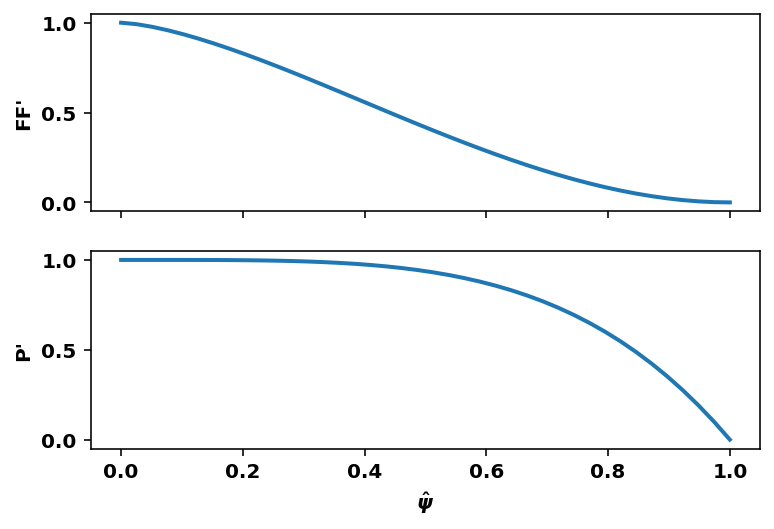

In [11]:
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 1.5
gamma = 2.0
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 4.0
gamma = 1.0
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [12]:
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  5.7964E+00  1.5693E-01  6.4678E-01  6.4426E+00  5.3471E-01  9.8348E+04
     2  1.5480E+01  9.5056E-02  2.7461E-01  6.4070E+00  5.3339E-01  1.5938E+05
     3  1.9148E+01  7.9380E-02  1.2980E-01  6.3865E+00  5.3263E-01  1.6630E+05
     4  2.0950E+01  7.3407E-02  6.7567E-02  6.3756E+00  5.3231E-01  1.6305E+05
     5  2.1908E+01  7.0680E-02  3.6961E-02  6.3696E+00  5.3223E-01  1.5882E+05
     6  2.2433E+01  6.9312E-02  2.0656E-02  6.3664E+00  5.3227E-01  1.5558E+05
     7  2.2724E+01  6.8590E-02  1.1646E-02  6.3646E+00  5.3236E-01  1.5342E+05
     8  2.2888E+01  6.8197E-02  6.5901E-03  6.3636E+00  5.3246E-01  1.5207E+05
     9  2.2980E+01  6.7980E-02  3.7354E-03  6.3630E+00  5.3254E-01  1.5127E+05
    10  2.3032E+01  6.7859E-02  2.1196E-03  6.3627E+00  5.3261E-01  1.5079E+05
    11  2.3061E+01  6.7791E-02  1.2038E-03  6.3626E+00  5.3267E-01  1.5051E+05
    12  2.3078E+01  6.7753E-02  6.8427E-04  6.3625E+00  5.3270E-01  1.5035E+05
    13  2.3087E+01  6.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

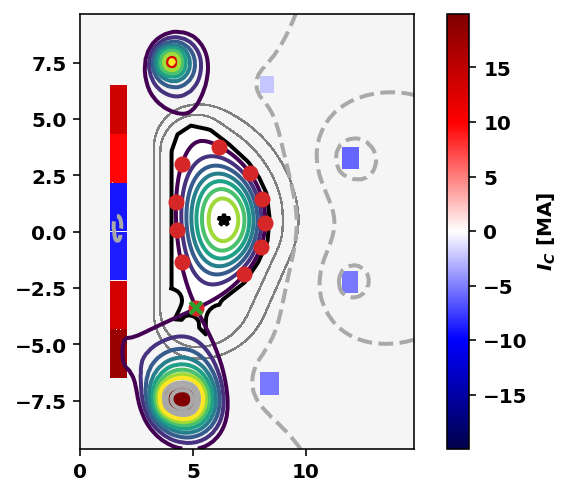

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents" method, which are all within the approximate coil limits imposed above.

In [14]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.5600E+07
  Current Centroid [m]    =    6.203  0.530
  Magnetic Axis [m]       =    6.362  0.533
  Elongation              =    1.868 (U:  1.739, L:  1.997)
  Triangularity           =    0.464 (U:  0.384, L:  0.544)
  Plasma Volume [m^3]     =   820.097
  q_0, q_95               =    0.823  2.760
  Peak Pressure [Pa]      =    6.1923E+05
  Stored Energy [J]       =    2.4299E+08
  <Beta_pol> [%]          =   39.7065
  <Beta_tor> [%]          =    1.7689
  Diamagnetic flux [Wb]   =    1.5403E+00
  Toroidal flux [Wb]      =    1.2187E+02
  l_i                     =    0.9049

Coil Currents [MA]:
  CS3U:           13.74
  CS2U:            9.74
  CS1U:           -9.06
  CS1L:           -8.81
  CS2L:           13.40
  CS3L:           17.88
  PF1:            12.94
  PF2:            -2.20
  PF3:            -5.95
  PF4:            -5.14
  PF5:            -5.18
  PF6:            19.93
  VSU:        

## Raise pressure pedestal to H-mode, treating toroidal current self-consistently

### Define useful functions and specify H-mode profiles

**Note from Daniel:** I'm using the Grad-Shafranov equation used in FreeGS but it lacks the factor of 0.5 we've talked about. 

In [15]:
def scale_jtor_to_ffprime(jtor, R_avg, one_over_R_avg, pprime, mu0):
    r'''! Convert from J_toroidal to FF' using Grad-Shafranov equation

    @param jtor Toroidal current profile
    @param R_avg Flux averaged R, calculated by TokaMaker
    @param one_over_R_avg Flux averaged 1/R, calculated by TokaMaker
    @param pprime dP/dPsi profile
    '''
    ffprime = (jtor -  R_avg * (-pprime)) * (mu0 / one_over_R_avg)
    return ffprime

Using the OMFIT Hmode_profiles() profile parametrization function, we can specify ITER-like H-mode profiles. See Figs. 18 and 19 for these $n_e$ and $T_e$ profiles: https://iopscience.iop.org/article/10.1088/0029-5515/48/7/075005/pdf

Additionally, we specify an L-mode toroidal current profile, to which we will add a non-inductive component generated by the boostrap current and calculated by the Sauter formula. 

For pressure, we are assuming a quasineutral and isothermal plasma, (i.e. ne = ni, Te = Ti), however this assumption is not usually valid in the core and separate ion profiles will need to be specified. Our final necessary assumption is that the profiles are "stiff", where the core pressure rises approximately equivalently to the pedestal pressure. 

In [16]:
### Define ne and Te profiles
xphalf = 0.965
widthp_Te = 0.1
widthp_ne = 0.35

ne = Hmode_profiles(edge=0.1, ped=0.6, core=1.1, rgrid=n_sample, expin=1.6, expout=1.6, widthp=widthp_ne, xphalf=xphalf) * 1e20
Te = Hmode_profiles(edge=0.001, ped=5., core=22., rgrid=n_sample, expin=1.3, expout=1.7, widthp=widthp_Te, xphalf=xphalf)
ni = ne.copy() # Assuming quasineutrality
Ti = Te.copy() # Assuming isothermal
pressure = (1.602e-16 * ne * Te) + (1.602e-16 * ni * Ti)

### Set up possible L-mode, inductive Jtor
jtor_noBS = Hmode_profiles(edge=0.0, ped=0.01, core=1.7, rgrid=n_sample, expin=1.0, expout=1.4, widthp=0.001, xphalf=None) * 1e+6

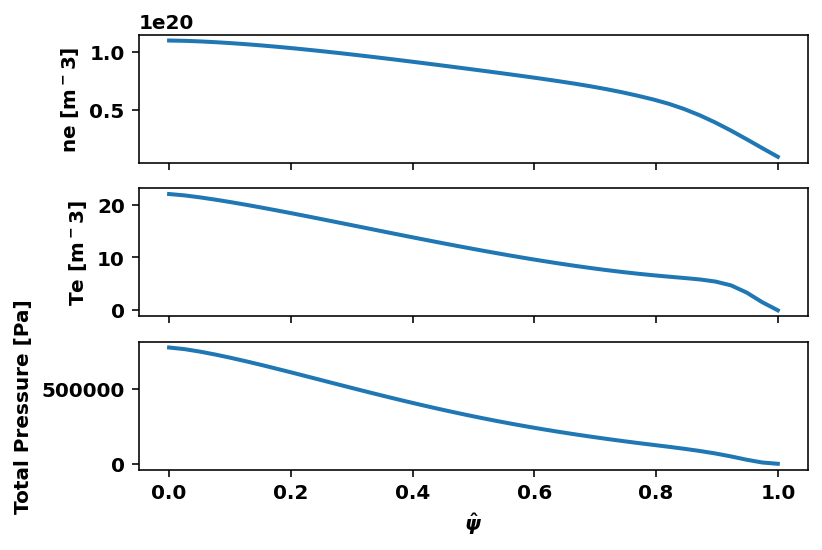

In [17]:
fig, ax = plt.subplots(3,1,sharex=True)
# Plot ne
ax[0].plot(psi_sample,ne)
ax[0].set_ylabel("ne [m$^-3$]")
# Plot Te
ax[1].plot(psi_sample,Te)
ax[1].set_ylabel("Te [m$^-3$]")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")
# Plot total pressure
ax[2].plot(psi_sample,pressure)
ax[2].set_ylabel("Total Pressure [Pa]")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

Here we take several steps to prepare our inputs to the Sauter formula, obtain our $j_{bootstrap}$ profile, add it to our non-inductive $j_{tor}$, and specify our new P' and F*F' profiles. 

In [18]:
### Convert keV to eV
Te *= 1000
Ti *= 1000

### Set new pax target
mygs.set_targets(pax=pressure[0],Ip=Ip_target)

### Calculate flux derivatives for Sauter
pprime = np.gradient(pressure) / (np.gradient(psi_sample) * (mygs.psi_bounds[1]-mygs.psi_bounds[0]))
dn_e_dpsi = np.gradient(ne) / (np.gradient(psi_sample) * (mygs.psi_bounds[1]-mygs.psi_bounds[0]))
dT_e_dpsi = np.gradient(Te) / (np.gradient(psi_sample) * (mygs.psi_bounds[1]-mygs.psi_bounds[0]))
dn_i_dpsi = np.gradient(ni) / (np.gradient(psi_sample) * (mygs.psi_bounds[1]-mygs.psi_bounds[0]))
dT_i_dpsi = np.gradient(Ti) / (np.gradient(psi_sample) * (mygs.psi_bounds[1]-mygs.psi_bounds[0]))

### Get final remaining quantities for Sauter from TokaMaker
psi,f,fp,p,pp = mygs.get_profiles(npsi=n_sample)
psi_st,fc,r_avgs,modb_avgs = mygs.sauter_fc(npsi=n_sample)
ft = 1 - fc # Trapped particle fraction on each flux surface
eps = r_avgs[2] / r_avgs[0] # Inverse aspect ratio
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(npsi=n_sample)
R_avg = ravgs[0]
one_over_R_avg = ravgs[1]

### Sauter impurity inputs (can be refined)
Zeff=np.linspace(1.5,1.5,n_sample) ### this is a horizontal "profile"
Zis=[1.]

### Solve for bootstrap current profile. See https://omfit.io/_modules/omfit_classes/utils_fusion.html for more detailed documentation 
j_BS = sauter_bootstrap(
                        psi_N=psi_sample,
                        Te=Te,
                        Ti=Ti,
                        ne=ne,
                        p=pressure,
                        dp_dpsi = pprime,
                        nis=None,
                        Zis=Zis,
                        Zeff=Zeff,
                        gEQDSKs=[None,None],
                        R0=R0,
                        device=None,
                        psi_N_efit=None,
                        psiraw=psi*(mygs.psi_bounds[1]-mygs.psi_bounds[0]) + mygs.psi_bounds[0],
                        R=R_avg,
                        eps=eps, 
                        q=qvals,
                        fT=ft,
                        I_psi=f,
                        nt=1,
                        version='osborne',
                        debug_plots=False,
                        return_units=True,
                        return_package=False,
                        charge_number_to_use_in_ion_collisionality='Koh',
                        charge_number_to_use_in_ion_lnLambda='Zavg',
                        dT_e_dpsi=dT_e_dpsi,
                        dT_i_dpsi=dT_i_dpsi,
                        dn_e_dpsi=dn_e_dpsi,
                        dnis_dpsi=dn_i_dpsi,
                        )[0]

mu0 = 1.2566370614359173e-06

jtor_total = jtor_noBS + j_BS
ffprime = scale_jtor_to_ffprime(jtor_total, ravgs[0], ravgs[1], pprime, mu0)


ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': ffprime / ffprime[0]
}

pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': pprime / pprime[0]
}

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


### Recompute Equilibrium

In [19]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  2.7012E+01  3.7378E-02  6.3791E-02  6.3703E+00  5.3231E-01  1.2414E+05
     2  2.7291E+01  3.7826E-02  2.2915E-02  6.3753E+00  5.3185E-01  1.1110E+05
     3  2.7503E+01  3.7850E-02  6.4338E-03  6.3779E+00  5.3148E-01  1.0839E+05
     4  2.7654E+01  3.7782E-02  2.4331E-03  6.3791E+00  5.3119E-01  1.0807E+05
     5  2.7756E+01  3.7710E-02  1.9739E-03  6.3797E+00  5.3099E-01  1.0821E+05
     6  2.7823E+01  3.7656E-02  1.6605E-03  6.3799E+00  5.3085E-01  1.0865E+05
     7  2.7868E+01  3.7619E-02  1.1488E-03  6.3800E+00  5.3075E-01  1.0892E+05
     8  2.7897E+01  3.7594E-02  7.9797E-04  6.3800E+00  5.3069E-01  1.0913E+05
     9  2.7915E+01  3.7577E-02  5.3650E-04  6.3800E+00  5.3064E-01  1.0926E+05
    10  2.7927E+01  3.7567E-02  3.5268E-04  6.3800E+00  5.3061E-01  1.0936E+05
    11  2.7935E+01  3.7560E-02  2.2906E-04  6.3799E+00  5.3059E-01  1.0941E+05
    12  2.7940E+01  3.7556E-02  1.4775E-04  6.3799E+00  5.3058E-01  1.0945E+05
    13  2.7943E+01  3.

Plot converged H-mode P' and F*F' profiles

Text(0.5, 1.0, "H-mode P' and FF'")

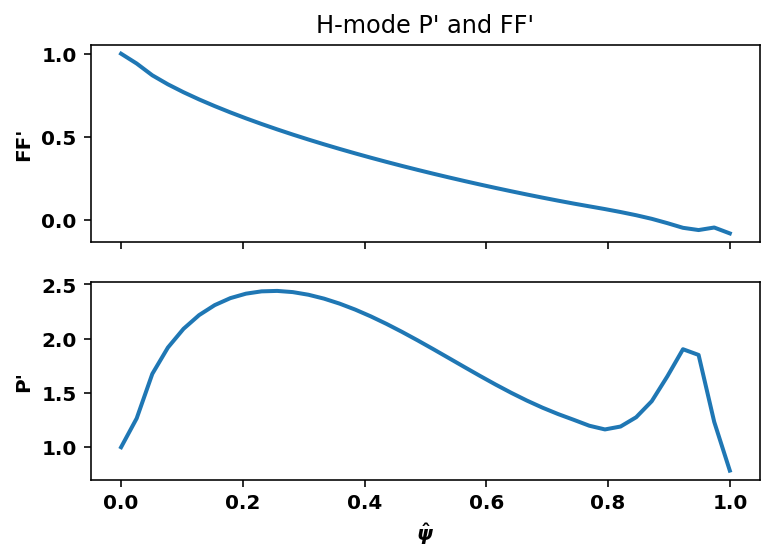

In [20]:
fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

ax[0].set_title("H-mode P' and FF'")

### Replot Equilibrium

Text(0.5, 1.0, 'H-mode Equilibrium')

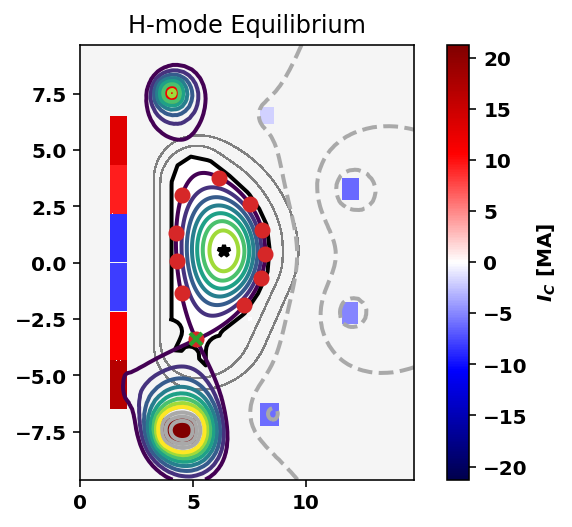

In [21]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')
ax.set_title('H-mode Equilibrium')

## Compute Forward Equilibrium
We will now demonstrate how to compute a forward equilibrium with known coil currents. Note that this method generally requires a known equilibrium, either from experimental observations or another code, as the Grad-Shafranov equation represents force-balance and as such solutions only exist for appropriate combinations of the plasma current and pressure and the supporting coil currents.

### Remove shape constraints from above
As we do not want to adjust the coil currents in the forward case, we must remove the shape targets from above, which can be done by passing `None` to both methods.

In [22]:
mygs.set_isoflux(None)
mygs.set_saddles(None)

### Set coil currents
We now set coil currents in TokaMaker to those from a known equilibrium solution.

In [23]:
eq_currents = {
    'CS3U': 5180.432355*553,
    'CS2U': -16660.61401*553,
    'CS1U': -36367.32465*553,
    'CS1L': -36367.32465*553,
    'CS2L': -16472.05814*553,
    'CS3L': 8671.71887*553,
    'PF1': 21725.94264*248.6,
    'PF2': -22213.70001*115.2,
    'PF3': -31877.98793*185.9,
    'PF4': -26721.1652*169.9,
    'PF5': -38450.07502*216.8,
    'PF6': 39603.47595*459.4,
    'VSU': 0.0,
    'VSL': 0.0
}
new_coil_currents = np.zeros((mygs.ncoils,))
for key, coil in coil_dict.items():
    new_coil_currents[coil['coil_id']] = eq_currents[key]
mygs.set_coil_currents(new_coil_currents)

### Set global targets
Again we define a target for the plasma current, but instead of a target pressure we constrain the radial and vertical position of the magnetic axis to match the equilibrium solution corresponding to the specified coil currents. During the solve the radial position is used to control the plasma pressure and VSC set is used to match the vertical position.

In [24]:
R0_target = 6.37
Z0_target = 0.51
mygs.set_targets(Ip=Ip_target, R0=R0_target, V0=Z0_target)

### Compute equilibrium

In [25]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  3.6696E+01  2.1627E-02  6.8196E-01  6.3799E+00  5.3055E-01 -4.3217E+04
     2  4.1055E+01  1.2549E-02  1.3777E-01  6.3786E+00  5.2772E-01 -1.0639E+05
     3  4.3930E+01  8.6304E-03  3.3993E-02  6.3770E+00  5.2443E-01 -8.9212E+04
     4  4.7098E+01  6.0339E-03  1.8198E-02  6.3753E+00  5.2104E-01 -8.4918E+04
     5  4.9960E+01  3.7980E-03  1.5161E-02  6.3737E+00  5.1763E-01 -8.6196E+04
     6  5.2466E+01  1.8657E-03  1.3476E-02  6.3720E+00  5.1421E-01 -8.8176E+04
     7  5.4420E+01  4.7205E-04  1.0589E-02  6.3704E+00  5.1080E-01 -8.5129E+04
     8  5.4434E+01  1.9096E-03  1.2232E-02  6.3701E+00  5.1016E-01 -7.6569E+03
     9  5.5039E+01  1.4519E-03  5.1414E-03  6.3700E+00  5.1003E-01 -3.2898E+04
    10  5.5621E+01  9.9537E-04  4.4969E-03  6.3700E+00  5.1001E-01 -4.0662E+04
    11  5.6058E+01  7.2159E-04  3.4836E-03  6.3700E+00  5.1000E-01 -3.9627E+04
    12  5.6378E+01  5.3168E-04  2.8549E-03  6.3700E+00  5.1000E-01 -3.8827E+04
    13  5.6639E+01  3.

### Print information and plot equilibrium

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.5598E+07
  Current Centroid [m]    =    6.254  0.513
  Magnetic Axis [m]       =    6.370  0.510
  Elongation              =    1.419 (U:  1.404, L:  1.435)
  Triangularity           =    0.217 (U:  0.220, L:  0.214)
  Plasma Volume [m^3]     =   771.797
  q_0, q_95               =    0.433  1.953
  Peak Pressure [Pa]      =   -2.1735E+03
  Stored Energy [J]       =   -8.3005E+05
  <Beta_pol> [%]          =   -0.1210
  <Beta_tor> [%]          =   -0.0065
  Diamagnetic flux [Wb]   =    2.7028E+00
  Toroidal flux [Wb]      =    1.1260E+02
  l_i                     =    1.4194


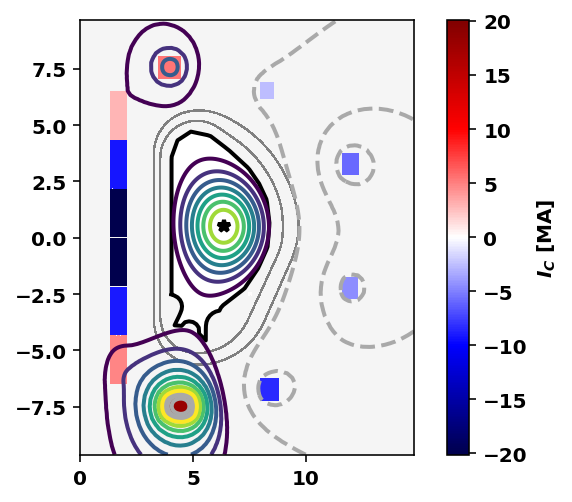

In [26]:
mygs.print_info()
#
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)